In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from IPython.display import Audio
sound_file = './beep-01a.wav'

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_v2.csv')

### Because the purpose of this movement is to interpolate risk factor, we are justified to bring in the testing data to train this model

To begin, we build the dataset using which we will train the model. First we select all lines that have risk factor, and fill missing values

In [3]:
# Get a sense of what columns the dataset contains
print np.unique(train_data.columns)

['A' 'B' 'C' 'C_previous' 'D' 'E' 'F' 'G' 'age_oldest' 'age_youngest'
 'car_age' 'car_value' 'cost' 'customer_ID' 'day' 'duration_previous'
 'group_size' 'homeowner' 'location' 'married_couple' 'record_type'
 'risk_factor' 'shopping_pt' 'state' 'time']


In [101]:
merged_data = train_data.append(test_data, ignore_index=True)
merged_data['average_age'] = (merged_data.age_oldest - merged_data.age_youngest) / 2
merged_data_no_purchase = merged_data[merged_data.record_type == 0].reset_index()
merged_data_max_shopping_pt = merged_data_no_purchase.iloc[merged_data_no_purchase.groupby('customer_ID').shopping_pt.idxmax()]

In [112]:
merged_data_max_shopping_pt = merged_data_max_shopping_pt.reset_index().drop(['level_0', 'index'], axis=1)

In [163]:
merged_data_risk_notnull = merged_data_max_shopping_pt[merged_data_max_shopping_pt.risk_factor.notnull()].reset_index().drop('index', axis=1)
merged_data_risk_predictors = merged_data_risk_notnull[['state', 'location', 
                                         'homeowner', 'car_age',
                                         'car_value', 'average_age', 
                                         'married_couple', 'duration_previous']]
merged_data_risk_label = merged_data_risk_notnull.risk_factor

In [132]:
# Find out what columns have empty values
def any_null(series):
    return any(series.isnull())
merged_data_risk_predictors.apply(any_null)

state                False
location              True
homeowner            False
car_age              False
car_value             True
average_age          False
married_couple       False
duration_previous     True
dtype: bool

In [133]:
# Interpolate customer location by using the mode of the locations in the state
mode = lambda x: int(scipy.stats.mode(x)[0][0])
state_location_mode = merged_data_risk_predictors.groupby('state')['location'].apply(mode)
Audio(url=sound_file, autoplay=True)

In [134]:
# Fill empty location cells with the location mode of the corresponding states
get_state_location = lambda state: state_location_mode[state]
merged_data_empty_location = merged_data_risk_predictors[merged_data_risk_predictors.location.isnull()]
#merged_data_risk_predictors.state.apply(get_state_location)
merged_data_empty_location.location = merged_data_empty_location.state.apply(get_state_location)
merged_data_risk_predictors[merged_data_risk_predictors.location.isnull()] = merged_data_empty_location

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
# Assign 'none' for all blank car values, because it can be assumed that those customers with that column blank have no cars. 
# They belong to a separate class
merged_data_risk_predictors.car_value[merged_data_risk_predictors.car_value.isnull()] = 'n'

# Assign 0 for all blank duration_previous, because it can be assumed that these customers are new
merged_data_risk_predictors.duration_previous[merged_data_risk_predictors.duration_previous.isnull()] = 0

D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
# Check that the dimension for predictor and labels match
assert len(merged_data_risk_predictors) == len(merged_data_risk_label)

Then, I want to perform a significance testing, maybe some exploratory analysis at first to make sure that these labels have any relationship at all with the label

In [137]:
significance_test_data = merged_data_risk_predictors.copy()
significance_test_data['risk_factor'] = merged_data_risk_label

In [138]:
index

array([    0,     1,     2, ..., 35291, 35292, 35293])

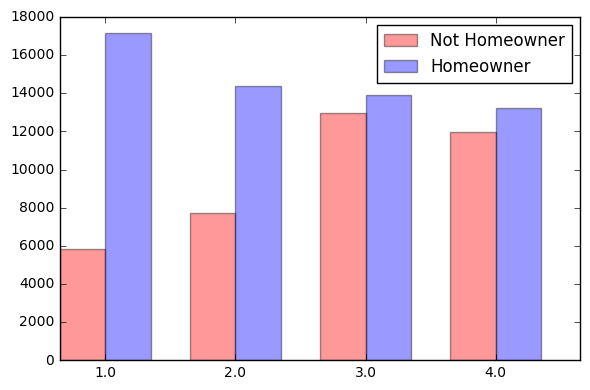

In [139]:
# First, I want to see if there is any relationshp between homeowner and risk factor
groupedby_homeowner = significance_test_data.groupby(['risk_factor', 'homeowner']).count().state
#groupedby_homeowner.index
groupedby_nohome = significance_test_data[significance_test_data.homeowner == 0].groupby('risk_factor').count().state.values
groupedby_home = significance_test_data[significance_test_data.homeowner == 1].groupby('risk_factor').count().state.values
# Visualization
n_groups = len(np.unique(significance_test_data.risk_factor))
index = np.arange(n_groups)
opacity=0.4

bar_width = 0.35
plt.bar(index, groupedby_nohome, bar_width,
        alpha=opacity,
        color='r',
        label='Not Homeowner')
plt.bar(index + bar_width, groupedby_home, bar_width,
        alpha=opacity,
        color='b',
        label='Homeowner')

plt.legend()
plt.xticks(index + bar_width, sorted(np.unique(significance_test_data.risk_factor)))
plt.tight_layout()
plt.show()

### It appears that indeed, owning a home has an impact on the risk factor

In [140]:
# Next: car age
np.unique(significance_test_data.car_age.values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 55, 57, 58, 59, 60, 61, 64, 65, 74, 75, 85], dtype=int64)

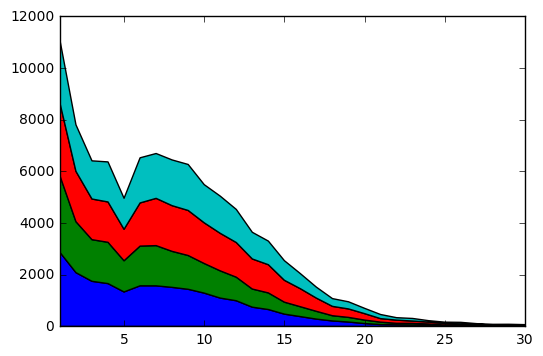

In [141]:
risk1 = significance_test_data[significance_test_data.risk_factor == 1.0].groupby('car_age').count().state
risk2 = significance_test_data[significance_test_data.risk_factor == 2.0].groupby('car_age').count().state
risk3 = significance_test_data[significance_test_data.risk_factor == 3.0].groupby('car_age').count().state
risk4 = significance_test_data[significance_test_data.risk_factor == 4.0].groupby('car_age').count().state
#print len(risk1), len(risk2), len(risk3), len(risk4)
index = np.arange(86)
#plt.plot(risk1.values, '-', label='1.0')
#plt.plot(risk2.values, '-', label='2.0')
#plt.plot(risk3.values, '-', label='3.0')
#plt.plot(risk4.values, '-', label='4.0')

plt.stackplot(index, risk1.reindex(index, fill_value=0), risk2.reindex(index, fill_value=0), 
              risk3.reindex(index, fill_value=0), risk4.reindex(index, fill_value=0))
plt.xlim([1, 30])
plt.legend()
plt.show()

### There does not seem to be a visible relationship between car age and risk factor

In [142]:
# Cross-validate using logistic regression model, because in any case, 
# the regression result will tell us what part of the model is helpful
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [143]:
# Prepare the data for learning
ordinal_features = ['car_value']
le = LabelEncoder()
merged_data_risk_predictors['car_value_code'] = le.fit_transform(merged_data_risk_predictors[ordinal_features])
#merged_data_risk_predictors.head()

D:\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [144]:
predictors = ['homeowner', 'car_value_code', 'average_age', 'married_couple', 'duration_previous']
X = merged_data_risk_predictors[predictors]
y = merged_data_risk_label
logreg = LogisticRegression(random_state=0)
clf = cross_val_score(logreg, X, y, cv=5)
Audio(url=sound_file, autoplay=True)

In [145]:
clf

array([ 0.31967297,  0.3255515 ,  0.31773538,  0.32457448,  0.32405884])

In [146]:
np.mean(clf)

0.32231863530141214

### It seems that logistic regression is not very useful in this case. The result is better than 25%-correct prediction, which is the random guessing benchmark. 

### Next, we want to use PCA to find some patterns at first, perhaps

In [147]:
from sklearn.decomposition import PCA

In [148]:
predictors = ['homeowner', 'car_value_code', 'average_age', 'married_couple', 'duration_previous']
X = merged_data_risk_predictors[predictors]
predictors_pca = PCA(n_components=2)
predictors_pca.fit(X.values)
#predictors_pca.transform(merged_data_risk_predictors)

PCA(copy=True, n_components=2, whiten=False)

In [178]:
single_attr_vec = np.diag(np.ones(5))
vec_transformed = predictors_pca.transform(single_attr_vec)

In [177]:
vec_transformed

array([[-6.87964182,  0.42269607],
       [-6.89082554,  0.43606247],
       [-6.78441039, -0.5590061 ],
       [-6.8922957 ,  0.40465691],
       [-5.90725669,  0.54996216]])

In [179]:
single_attr_vec

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

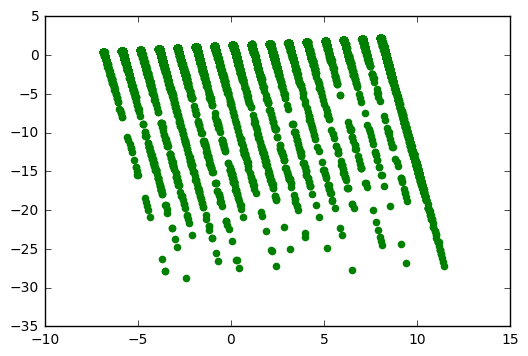

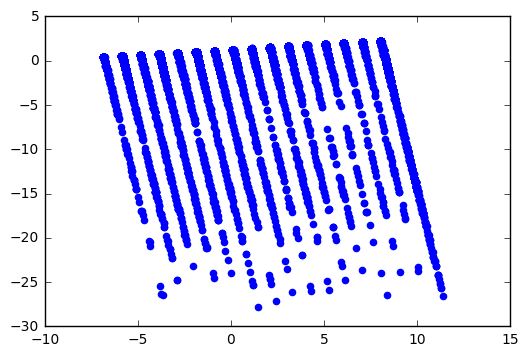

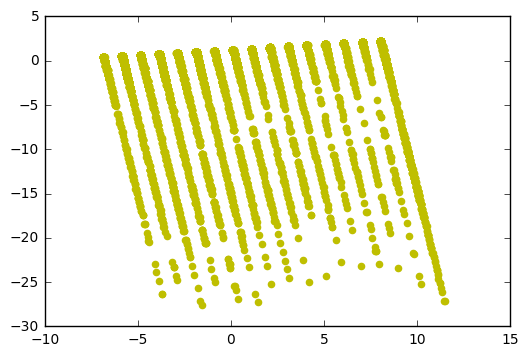

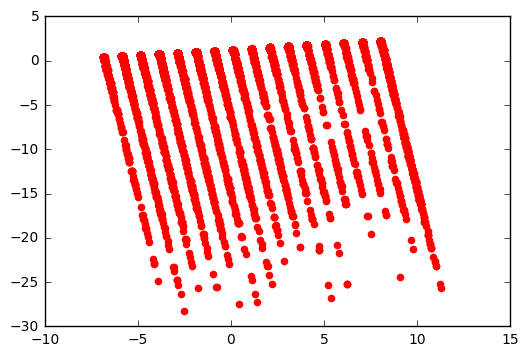

In [181]:
X_transformed = pd.DataFrame(predictors_pca.transform(X))
y = merged_data_risk_label
#colors = {1: 'green', 2: 'blue', 3: 'yellow', 4: 'red'}
#plt.scatter(X_transformed[:, 0], X_transformed[:, 1], color=y.apply(lambda x: colors[x]))
X_1 = X_transformed[y == 1]
X_2 = X_transformed[y == 2]
X_3 = X_transformed[y == 3]
X_4 = X_transformed[y == 4]
#plt.scatter(X_1[0], X_1[1], color='b')
plt.scatter(X_1[0], X_1[1], color='g')
plt.show()
plt.scatter(X_2[0], X_2[1], color='b')
plt.show()
plt.scatter(X_3[0], X_3[1], color='y')
plt.show()
plt.scatter(X_4[0], X_4[1], color='r')
plt.show()

In [60]:
predictors_pca.transform(np.array([1,0,0,0,0]))

D:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[-6.75003486,  0.44709545]])

In [59]:
print(predictors_pca.explained_variance_ratio_) 

[ 0.6069328   0.34481353]


In [50]:
X

,homeowner,car_value_code,average_age,married_couple,duration_previous
0,0,6,2.0,1,2.0
1,0,6,2.0,1,2.0
2,0,6,2.0,1,2.0
3,0,6,2.0,1,2.0
4,0,6,2.0,1,2.0
5,0,6,2.0,1,2.0
6,0,6,2.0,1,2.0
7,0,6,2.0,1,2.0
8,0,6,2.0,1,2.0
9,0,4,0.0,0,13.0
